In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os


# Rock Paper Scissors Dataset Analysis
This section loads and examines the rock-paper-scissors object detection dataset. We'll load the annotation data from a CSV file and perform initial data exploration to understand the structure and quality of our dataset.

The dataset contains bounding box annotations for hand gestures representing rock, paper, and scissors poses, which will be used for training an object detection model.

In [7]:
df_image_info = pd.read_csv('./test/_annotations.csv')
df_image_info.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_7079_MOV-23_jpg.rf.123a8de8c8da646e4a25f1c...,640,640,Rock,39,185,414,443
1,egohands-public-1623358709389_png_jpg.rf.01566...,640,640,Paper,131,40,277,234
2,Screen-Shot-2022-02-14-at-1-09-28-PM_png.rf.00...,640,640,Paper,0,73,156,483
3,Screen-Shot-2022-02-08-at-12-58-48-PM_png.rf.0...,640,640,Rock,45,335,148,548
4,egohands-public-1626966067167_png_jpg.rf.078d6...,640,640,Rock,142,316,318,501


In [57]:
df_image_info

,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_7079_MOV-23_jpg.rf.123a8de8c8da646e4a25f1c...,640,640,Rock,39,185,414,443
1,egohands-public-1623358709389_png_jpg.rf.01566...,640,640,Paper,131,40,277,234
2,Screen-Shot-2022-02-14-at-1-09-28-PM_png.rf.00...,640,640,Paper,0,73,156,483
3,Screen-Shot-2022-02-08-at-12-58-48-PM_png.rf.0...,640,640,Rock,45,335,148,548
4,egohands-public-1626966067167_png_jpg.rf.078d6...,640,640,Rock,142,316,318,501
...,...,...,...,...,...,...,...,...
199,egohands-public-1623712844639_png_jpg.rf.f367a...,640,640,Paper,174,388,381,473
200,egohands-public-1626386619095_png_jpg.rf.f19df...,640,640,Rock,374,225,634,483
201,zoom_tests_RockPaperScissors-mohamed_mp4-157_j...,640,640,Paper,0,107,325,475
202,egohands-public-1621214710295_png_jpg.rf.f776c...,640,640,Paper,281,463,470,607


In [56]:
df_image_info.describe()

,width,height,xmin,ymin,xmax,ymax
count,204.0,204.0,204.000000,204.000000,204.000000,204.000000
mean,640.0,640.0,204.019608,248.960784,438.887255,475.225490
std,0.0,0.0,134.908104,115.877498,143.825675,102.865679
min,640.0,640.0,0.000000,0.000000,114.000000,136.000000
25%,640.0,640.0,76.000000,166.250000,318.750000,415.500000
50%,640.0,640.0,202.000000,244.500000,443.000000,469.500000
75%,640.0,640.0,316.250000,340.750000,570.000000,548.000000
max,640.0,640.0,468.000000,468.000000,640.000000,640.000000


## Data Quality Check

Now let's examine the dataset for potential data quality issues, including duplicate values and other inconsistencies that could affect our model training.

In [58]:
# Check for duplicate rows
duplicate_rows = df_image_info.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

if duplicate_rows.sum() > 0:
    print("\nDuplicate rows found:")
    print(df_image_info[duplicate_rows])
else:
    print("No duplicate rows found.")

# Check for duplicate filenames
duplicate_filenames = df_image_info['filename'].duplicated()
print(f"\nNumber of duplicate filenames: {duplicate_filenames.sum()}")

if duplicate_filenames.sum() > 0:
    print("\nDuplicate filenames:")
    print(df_image_info[duplicate_filenames]['filename'].values)

# Check for any missing values
print(f"\nMissing values per column:")
print(df_image_info.isnull().sum())

# Check for invalid bounding box coordinates
invalid_boxes = df_image_info[(df_image_info['xmin'] >= df_image_info['xmax']) | 
                             (df_image_info['ymin'] >= df_image_info['ymax'])]
print(f"\nNumber of invalid bounding boxes: {len(invalid_boxes)}")

if len(invalid_boxes) > 0:
    print("Invalid bounding boxes found:")
    print(invalid_boxes)

Number of duplicate rows: 0
No duplicate rows found.

Number of duplicate filenames: 18

Duplicate filenames:
['youtube-115_jpg.rf.2800bdb9db9e04287b5e232bc67267f2.jpg'
 'IMG_7077_MOV-20_jpg.rf.5691c9cc997ed097c4e95215ad6426de.jpg'
 'IMG_7077_MOV-106_jpg.rf.70485649471c0d185b71d8061224b4b6.jpg'
 'youtube-56_jpg.rf.7676322ce508982f24ee8eb4f6266ab9.jpg'
 'youtube-127_jpg.rf.77b42072c208590f5ba5531781db8548.jpg'
 'youtube-117_jpg.rf.7bee65e734adbfd002489c416ede931f.jpg'
 'IMG_7077_MOV-32_jpg.rf.91d74f5f9c24078b4a2e6aa852c43c2f.jpg'
 'Screen-Recording-2023-03-11-at-9_48_18-PM_mov-289_jpg.rf.955e6ecd36bb97279951f81b4dd8e373.jpg'
 'youtube-124_jpg.rf.9e514844ec7d73ea9e3d480497bc959c.jpg'
 'youtube-124_jpg.rf.9e09975f0f79e0f6e7142a81fb8a203a.jpg'
 'IMG_7077_MOV-7_jpg.rf.b0eb4230274c3b51407b9c1034629203.jpg'
 'IMG_7077_MOV-19_jpg.rf.bc707fa7baf2981dd6b2cf4a68613fc8.jpg'
 'youtube-63_jpg.rf.ca761368d61451ada0968062870a7026.jpg'
 'IMG_7077_MOV-33_jpg.rf.cd465196b51e6ae745aa5eb93200382b.jpg'
 'Sc

In [ ]:
# List all available styles
print(plt.style.available)

# Use a popular built-in style like 'ggplot' instead
plt.style.use('_mpl-gallery')
# Get the correct class counts
class_counts = df_image_info['class'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Rock, Paper, Scissors Classes')
plt.grid(True, alpha=0.3)
plt.show()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## Sample Image Visualization

The following section demonstrates how the bounding box annotations are applied to actual images in our dataset. We'll visualize the first image with its corresponding bounding box to verify the accuracy of our annotation data.

This visualization helps us understand:
- How well the bounding boxes align with the actual hand gestures
- The quality of our annotation data
- Whether any adjustments are needed before training our object detection model

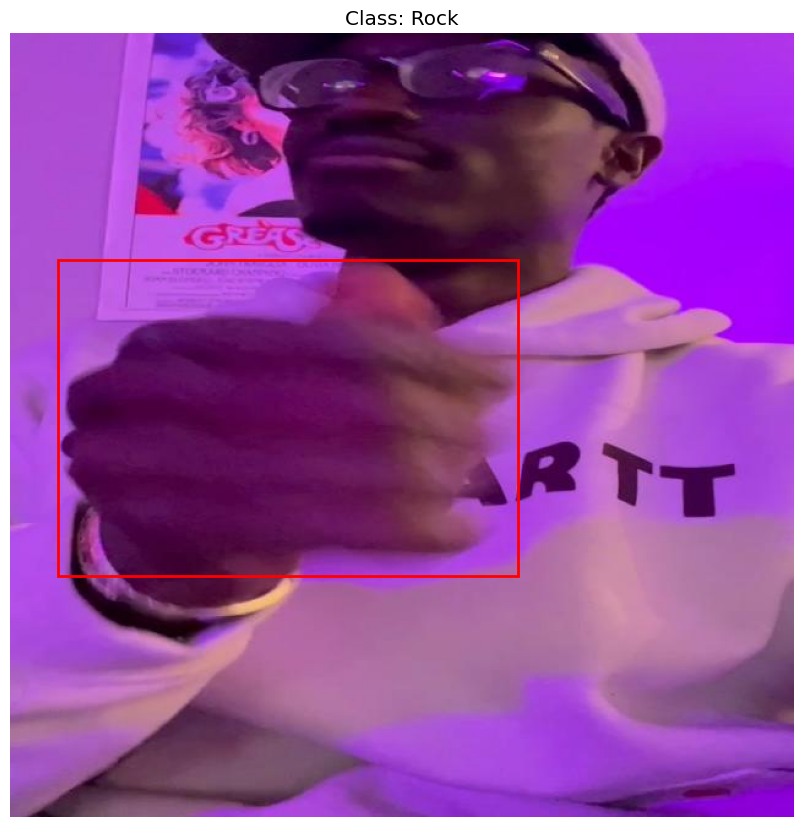

Target dictionary:
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Boxes: tensor([[ 39., 185., 414., 443.]])
Labels: tensor([1])


In [ ]:
current_path = os.getcwd()
image_path = f"./test/{df_image_info.loc[0, 'filename']}"
img = cv2.imread(image_path)

transform = T.Compose([
    T.ToTensor(),
])

# Load image
img = cv2.imread(image_path)
if img is not None:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
else:
    print(f"Error: Could not load image from path: {image_path}")
    print(f"Current directory: {current_path}")
    if os.path.exists(image_path):
        print("File exists but couldn't be read by cv2.imread()")
    else:
        print("File does not exist at the specified path")

# Load corresponding bounding boxes and labels
# Get bounding box coordinates from the first row
x1 = df_image_info.loc[0, 'xmin']
y1 = df_image_info.loc[0, 'ymin']
x2 = df_image_info.loc[0, 'xmax']
y2 = df_image_info.loc[0, 'ymax']

# Load image
if img is not None:
    # Load corresponding bounding boxes and labels
    boxes = [[x1, y1, x2, y2]]  # Single bounding box for the first image
    labels = [1]  # Assuming class labels: 1=Rock, 2=Paper, 3=Scissors

    # Create a target dictionary
    target = {}
    target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
    target["labels"] = torch.tensor(labels, dtype=torch.int64)

    # Visualize the image with bounding box
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', facecolor='none', linewidth=2))
    plt.title(f"Class: {df_image_info.loc[0, 'class']}")
    plt.axis('off')
    plt.show()

    print(f"Target dictionary:")
    print(f"Boxes shape: {target['boxes'].shape}")
    print(f"Labels shape: {target['labels'].shape}")
    print(f"Boxes: {target['boxes']}")
    print(f"Labels: {target['labels']}")
else:
    print(f"Error: Could not load image from path: {image_path}")
    print(f"Current directory: {current_path}")
    if os.path.exists(image_path):
        print("File exists but couldn't be read by cv2.imread()")
    else:
        print("File does not exist at the specified path")


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


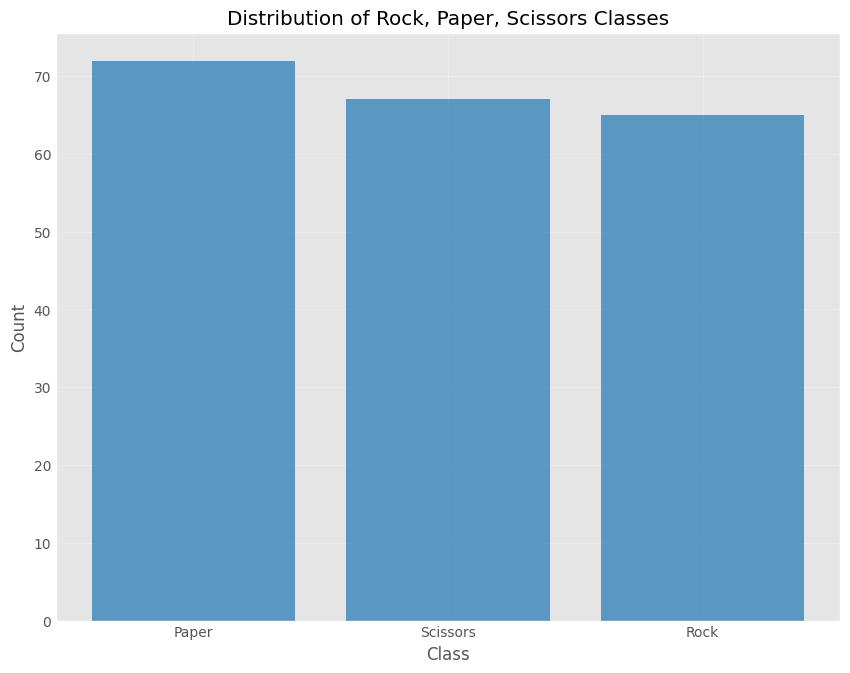

In [ ]:
# List all available styles
print(plt.style.available)

# Use a popular built-in style like 'ggplot' instead
plt.style.use('_mpl-gallery')
# Get the correct class counts
class_counts = df_image_info['class'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count') 
plt.title('Distribution of Rock, Paper, Scissors Classes')
plt.grid(True, alpha=0.3)
plt.show()